# Speech Emotion Recognition

In [ ]:
#%pip install playsound
#%pip install tensorflow --user
#%pip install librosa

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
import librosa
import os
from playsound import playsound
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Loading the dataset

In [2]:
# Create a new numpy array to store the .wav files
files = np.array([])
labels = np.array([])
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        # Reading the wav file
        if filename.endswith('.wav'):
            # Read the wav file (mono)
            files = np.append(files, os.path.join(dirname, filename))
            labels = np.append(labels, filename.split("_")[2])

## Audio Processing

In [3]:
def playAudio(path):
    playsound(path)
    
def getAudioSignal(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    # Find the time of the audio file
    time = np.linspace(0, len(signal) / frameRate, num=len(signal))
    return signal, time


def calculateZeroCrossingRate(audioPath, frameSize, hopSize):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.zero_crossing_rate( y= audio, frame_length= frameSize, hop_length= hopSize)[0]) # We can make center=True to get more accurate results

def calculateEnergy(audioPath, frameSize, hopSize):
    """
    audioPath: The path of the audio file
    frameSize: The number of samples in each frame
    hopSize: The number of samples between successive frames
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.rms(y = audio, frame_length= frameSize, hop_length= hopSize)[0]) # We can make center=True to get more accurate results

def calculateMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    """"
    n_fft: The number of points in the FFT, which determines the frequency resolution of the spectrogram
    hopSize: The number of samples between successive frames
    n_mels: The number of mel frequency bands to generate in the spectrogram
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    # Normalize between 0 and 1
    if mel_spec_db.max() - mel_spec_db.min() != 0:
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / ((mel_spec_db.max() - mel_spec_db.min()) + 1e-6) # eps for numerical stability
    else:
        mel_spec_db = mel_spec_db - mel_spec_db.min()
    return mel_spec_db


def plotSignal(signal, time):
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.show()

def plotHistogram(data, dataTitle):
    plt.figure(figsize=(15, 5))
    plt.hist(data, bins=15)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Histogram of the ' + dataTitle)
    plt.show()


### Reading, Plotting and Playing the Audio

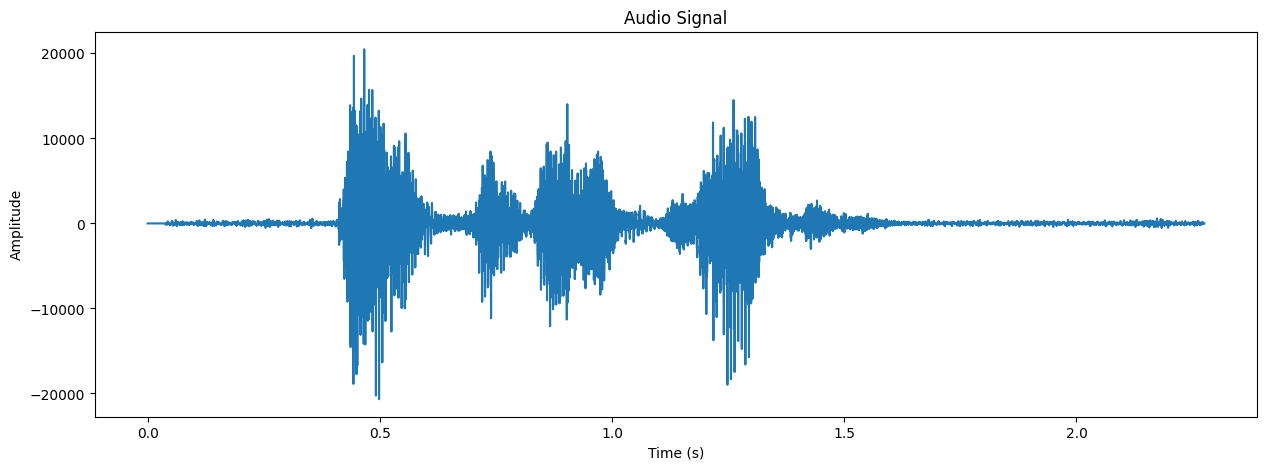

In [4]:
audioSignal, audioTime = getAudioSignal(files[0])
plotSignal(audioSignal, audioTime)
playAudio(files[0])

## Splitting the Dataset

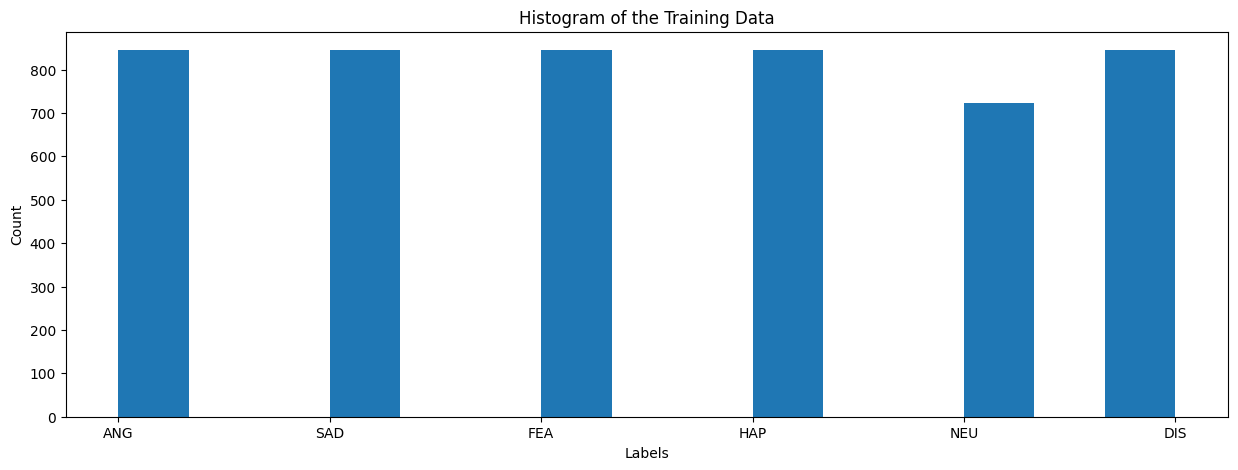

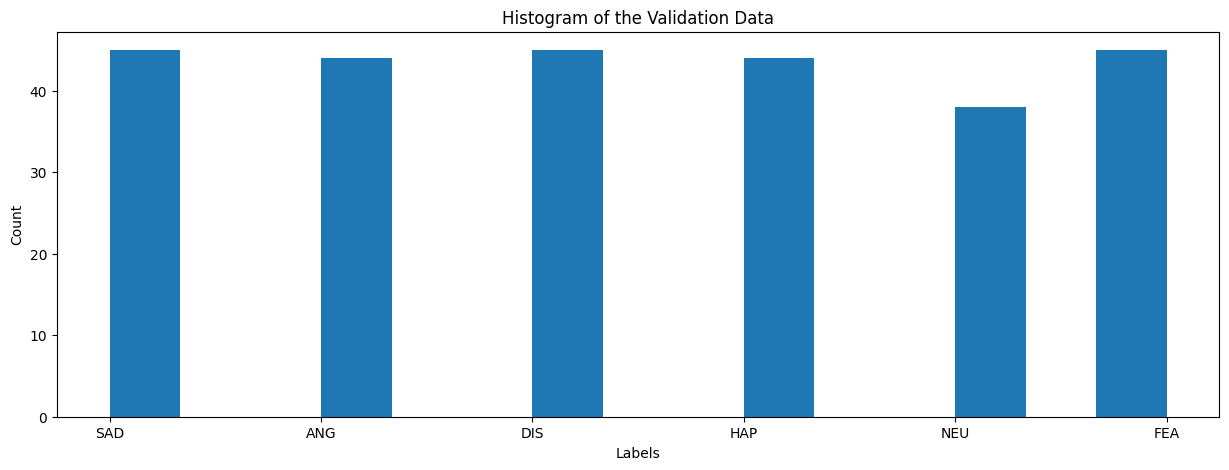

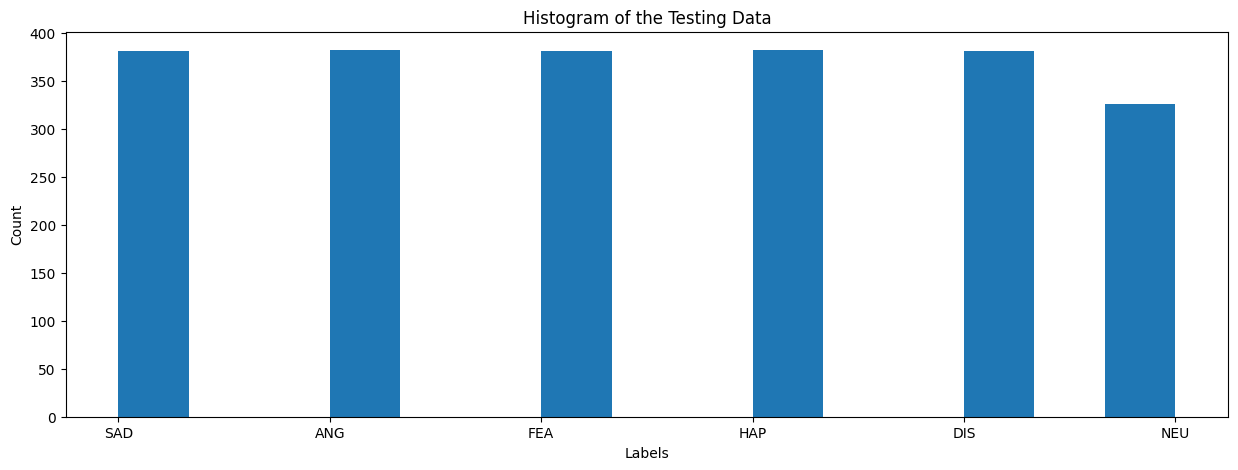

In [5]:
x_train_val, x_test, y_train_val, y_test = train_test_split(files, labels, train_size=0.7, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=0.95, random_state=42, stratify=y_train_val)
# Plotting the histogram of the training data
plotHistogram(y_train, 'Training Data')
# Plotting the histogram of the validation data
plotHistogram(y_val, 'Validation Data')
# Plotting the histogram of the testing data
plotHistogram(y_test, 'Testing Data')

In [6]:
print("Training Data shape: ", x_train.shape)
print("Validation Data shape: ", x_val.shape)
print("Testing Data shape: ", x_test.shape)

Training Data shape:  (4948,)
Validation Data shape:  (261,)
Testing Data shape:  (2233,)


- We have the choice of either undersampling or oversampling the dataset. We will not be using either of them as they are not very effective in this case since the differences in number of samples is not big. We will be using the entire dataset as it is.

## Feature Extraction

- We will create two feature spaces from the audio.
  - We can work on time domain, or we can work in frequency domain. There are multiple of features that can help improving the model:
    - Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
    - Energy: The sum of squares of the signal values, normalized by the respective frame length.
    - Extras:
      - Pitch: The fundamental frequency of the signal.
  - Convert the audio waveform to mel spectrogram and use this as the feature space.

In [ ]:
def extractFeatures(data, dataTitle, frameSize, hopSize, n_fft, n_mels):
    df = pd.DataFrame(columns=['zcr', 'energy', 'melSpectogram', 'label'])
    for i in range(len(data)):
        # Extracting the features
        zcr = calculateZeroCrossingRate(data[i], frameSize, hopSize)
        energy = calculateEnergy(data[i], frameSize, hopSize)
        melSpectogram = calculateMelSpectogram(data[i], n_fft, hopSize, n_mels)
        label = y_train[i]
        df = df.append({'zcr': zcr, 'energy': energy, 'melSpectogram': melSpectogram, 'label': label}, ignore_index=True)
    # Saving the dataframe to the csv file
    df.to_csv('processed/' + dataTitle + '.csv', index=False)
    return df

extractFeatures(x_train, 'train', 1024, 512, 1024, 128)
extractFeatures(x_val, 'val', 1024, 512, 1024, 128)
extractFeatures(x_test, 'test', 1024, 512, 1024, 128)

### Loading the saved features

In [7]:
# Reading the saved csv files
train_df = pd.read_csv('processed/train.csv')
val_df = pd.read_csv('processed/val.csv')
test_df = pd.read_csv('processed/test.csv')

y_train = np.array(train_df['label'].tolist())
y_val = np.array(val_df['label'].tolist())
y_test = np.array(test_df['label'].tolist())


x_train_zcr = np.array(train_df['zcr'].tolist())
x_train_energy = np.array(train_df['energy'].tolist())
x_train_melSpectogram = np.array(train_df['melSpectogram'].tolist())


x_val_zcr = np.array(val_df['zcr'].tolist())
x_val_energy = np.array(val_df['energy'].tolist())
x_val_melSpectogram = np.array(val_df['melSpectogram'].tolist())

x_test_zcr = np.array(test_df['zcr'].tolist())
x_test_energy = np.array(test_df['energy'].tolist())
x_test_melSpectogram = np.array(test_df['melSpectogram'].tolist())

In [9]:
print("Training Data shape: ", x_train_zcr.shape)
print("Validation Data shape: ", x_val_zcr.shape)
print("Testing Data shape: ", x_test_zcr.shape)

Training Data shape:  (4948,)
Validation Data shape:  (261,)
Testing Data shape:  (2233,)


## Building The model

In [ ]:
# We are going to experiment with a bunch of built in CNN architectures and see which one performs the best
# A bunch of models we can try:
# 1. VGG16
# 2. VGG19
# 3. ResNet50
# 4. InceptionV3
# 5. InceptionResNetV2
# 6. DenseNet121
# 7. DenseNet169
# 8. DenseNet201
# 9. Xception